# 1 Setup

In this module, we will use a CNN to identify different dog breeds.

In [1]:
# fastai library imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *

In [2]:
# cuda config
torch.cuda.set_device(0)

In [3]:
# env config
PATH = "./data/"
sz = 224
arch = resnext101_64
batch_size = 58

In [4]:
# set up k-folds cross validation
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val = get_cv_idxs(n)

# 2 Initial Exploration

In this section, we explore the data to understand what we're working with.

In [5]:
# path exploration
!ls {PATH}

labels.csv	sample_submission.csv	   test      tmp    train.zip
labels.csv.zip	sample_submission.csv.zip  test.zip  train


In [6]:
# create a pandas dataframe to explore labels
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Now, let's see how many of each breed exists

In [7]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


# 3 Initial Model

## 3.1 Precompute

In this section, we will retain all the precomputed activations of the resnet34 architecture to obtain a base model.

In [8]:
# transform/augment data and read it
def get_data(sz, batch_size):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', val_idxs=val, suffix='.jpg',
                                        tfms=tfms, bs=batch_size)
    return data if sz > 300 else data.resize(340, 'tmp')

In [9]:
# get data in desired format
data = get_data(sz, batch_size)

In [10]:
# run precomputed resnext101_64 model on our current dataset
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [11]:
# use cyclic learning rate finder to generate lr plot
lrf = learn.lr_find()

 76%|███████▌  | 107/141 [00:03<00:01, 33.52it/s, loss=11.2]


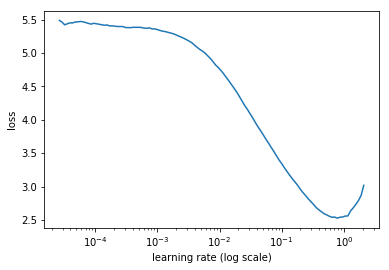

In [12]:
# plot the lr discovered to visualize and find optimal lr
learn.sched.plot()

In [13]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.944637   0.427012   0.905088  
    1      0.442964   0.333965   0.910959                    



[array([0.33397]), 0.9109589053926636]

## 3.2 Disable Precompute 

We can now disable precompute to allow the last two layers' weights to be adjusted for the current dataset

In [14]:
learn.precompute = False

In [15]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.367953   0.27781    0.916341  
    1      0.33413    0.270062   0.915362                    
    2      0.301416   0.261445   0.918297                    
    3      0.297776   0.255464   0.920254                    
    4      0.277221   0.250539   0.920254                    



[array([0.25054]), 0.920254406863696]

 Let's save this precomputed model with ~92.5% accuracy for safekeeping.

In [16]:
learn.save('224_pre')
learn.load('224_pre')

## 3.3 Increasing Size 

We will now increase the size of the images to *299x299* which will help avoid overfitting and generalize over the dataset

In [11]:
learn.set_data(get_data(299, batch_size))
learn.freeze() # freeze again just to be sure

In [12]:
# refit on new image sizes
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.271533   0.679444   0.889432  
    1      0.640297   0.42871    0.905577                    
    2      0.432723   0.345668   0.912916                    



[array([0.34567]), 0.9129158536048785]

## 3.4 Modifying Epochs 

In this section, we will play around with the epochs to try and maximize the effects of the stochastic gradient descent with random restarts. To do so, we will set ```cycle_mult=2``` so that the number of epochs is doubled in each cycle. Doing this also helps avoid underfitting by allowing more time to find global minima.

In [19]:
# refit with cycle_mult=2
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.211511   0.229217   0.92955   
    1      0.203454   0.22365    0.931996                    
    2      0.177324   0.222661   0.92955                     
    3      0.185279   0.231597   0.930039                    
    4      0.171828   0.225689   0.930528                    
    5      0.152407   0.220112   0.935421                    
    6      0.146382   0.219656   0.93591                     



[array([0.21966]), 0.9359099824134618]

 Let's save this model with ~93% accuracy for safekeeping.

In [28]:
learn.save('299_pre')

## 3.5 Predicting on Validation Data

In [41]:
# learn.load('299_pre')
# log_probs_tta,y = learn.TTA(is_test=True)
# probs = np.mean(np.exp(log_probs_tta), axis=0)
# preds = np.argmax(probs, axis=1)
# accuracy_np(probs, y)

log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
# probs = np.exp(log_preds)
probs.shape

(10357, 120)

# 4 Creating a Kaggle Submission

In [42]:
ds = pd.DataFrame(probs)
ds.columns = data.classes
id_series = pd.Series([o[5:-4] for o in data.test_ds.fnames])
ds.insert(0, 'id', id_series)
ds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,0.000004,0.000005,0.000009,0.000009,0.000003,0.000006,0.000003,0.000004,0.000005,...,1.807375e-07,7.769298e-07,0.000008,5.266584e-07,0.000009,0.000001,0.000002,0.000012,0.000003,1.246918e-07
1,6b423ca7020e70eb05732843c5d2bad1,0.000068,0.000165,0.000006,0.000403,0.000012,0.000008,0.000025,0.000035,0.000034,...,4.372932e-05,2.245142e-05,0.000022,3.004694e-06,0.000026,0.000004,0.000242,0.000018,0.000211,2.811578e-05
2,74aa7e201e0e93e13e87b986a7d31839,0.000714,0.000121,0.000076,0.018729,0.001758,0.000344,0.000194,0.000379,0.000651,...,4.640320e-04,6.252378e-04,0.000263,6.286239e-04,0.000086,0.000944,0.000406,0.000402,0.492364,1.947350e-04
3,a079f72193264bc5685e5d28d7372680,0.001183,0.000156,0.000095,0.001922,0.000115,0.000089,0.000606,0.000120,0.000220,...,2.327217e-04,1.726953e-03,0.000101,1.688560e-04,0.000358,0.000420,0.001437,0.000085,0.015837,2.362967e-03
4,583f7580fa5fec1266331fcf83b76fd6,0.000245,0.000008,0.000006,0.001116,0.000008,0.000018,0.000048,0.000021,0.000003,...,2.371163e-05,1.708265e-05,0.000002,5.001740e-06,0.000002,0.000003,0.000011,0.000001,0.000101,7.676960e-05


In [43]:
!mkdir subm # make directory called 'subm'

mkdir: cannot create directory ‘subm’: File exists


In [44]:
ds.to_csv(f'subm/subm.gz', compression='gzip', index=False)